# Nucleus Detection

### Next steps

* Train on data that isn't just the 256x256
* Work out a better way of deciding what is good (not just picking a cutoff..)
* the paper mentions something about how to init weights

### Mid term plans

* Data augmentation

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import data_loaders, prepare_submission, net, mask_prep, imcut
import helpers as h

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.autograd import Variable
from sklearn import model_selection
from tqdm import tqdm

# Data

In [53]:
train_raw, train_keys_raw = data_loaders.training_images()
summary_masks_raw, weights_raw = data_loaders.masks_and_weights("saved_weights")

In [54]:
train_shapes = {}
for i in range(len(train_raw)):
    img = train_raw[i]
    weight = weights_raw[i]
    mask = summary_masks_raw[i]
    if img.shape[0] < 256 or img.shape[1] < 256: raise Exception("We can't handle small training images")
    try:
        train_shapes[img.shape].append((img, weight, mask))
    except:
        train_shapes[img.shape] = [(img, weight, mask)]

In [63]:
train, weights, summary_masks = [], [], []
for shp, images in train_shapes.items():
    y_cut, x_cut = imcut.training_patchify(shp)
    for img_index in range(len(images)):
        for i in range(len(y_cut)):
            for j in range(len(x_cut)):
                train.append(images[img_index][0][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                weights.append(images[img_index][1][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])
                summary_masks.append(images[img_index][2][y_cut[i]:y_cut[i] + 256,x_cut[j]:x_cut[j] + 256])

In [64]:
trainT, valid, weightsT, valid_weights, summary_masksT, valid_summary_masks = model_selection.train_test_split(train, weights, summary_masks, test_size=0.2)

trainV, validV = h.tensorfy(trainT), h.tensorfy(valid)
weightsV, valid_weightsV = h.tensorfy(weightsT), h.tensorfy(valid_weights)
summary_masksV, valid_summary_masksV = h.tensorfy(summary_masksT), h.tensorfy(valid_summary_masks)

assert summary_masksV.shape == weightsV.shape and trainV.shape == weightsV.shape
print(summary_masksV.shape, type(trainV))

torch.Size([1779, 1, 256, 256]) <class 'torch.FloatTensor'>


# Exploration

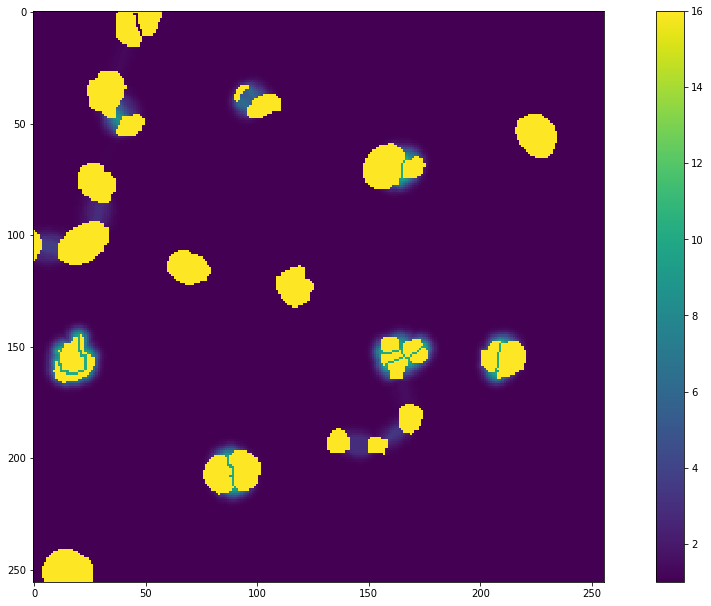

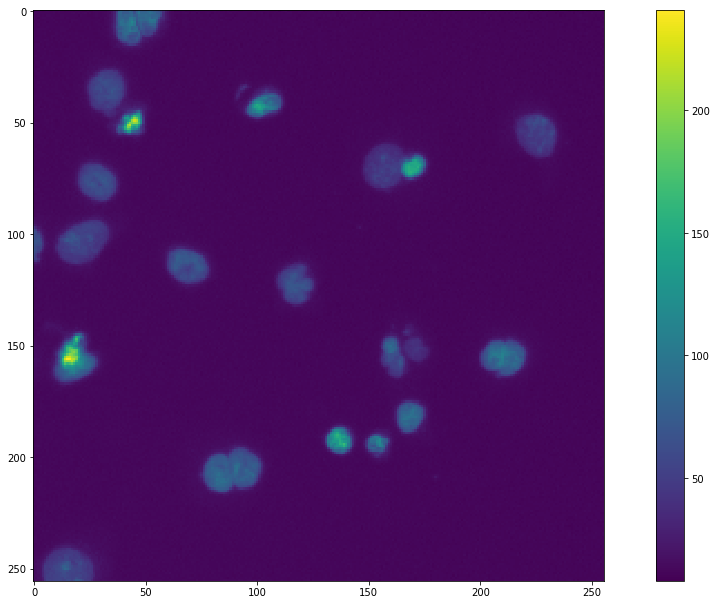

In [41]:
def plot(img):
    fig, ax = plt.subplots()
    fig.set_size_inches(18.5, 10.5)
    img = ax.imshow(img)
    fig.colorbar(img)
for i in [weights, train]:
    plot(i[3])


# Train

In [68]:
n = net.u_net().cuda()
# Large momentum because our batch size is small. We want many of the recent images to impact our move.
optimizer = torch.optim.SGD(n.parameters(), lr=0.0001, momentum=0.99)
batchsize = 1
losses = []
epoch_num = 0

In [86]:
for epoch in range(1):
    epoch_num += 1
    t = tqdm(range(len(trainV)), desc="{} Epoch".format(epoch_num))
    for i in t:
        s = i*batchsize
        # Define input data
        inp = trainV[s:s+batchsize]
        assert inp.shape == (batchsize, 1, 256, 256)
        inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
        assert inp.shape == (batchsize, 1, 348, 348)

        # Define expected data and weights
        weight = Variable(weightsV[i:i+batchsize]).cuda()
        assert weight.shape == (batchsize, 1, 256, 256)
        exp = Variable(summary_masksV[i:i+batchsize]).cuda()
        assert exp.shape == (batchsize, 1, 256, 256)

        # Ready net
        optimizer.zero_grad()

        # Run net and get output ready for loss and backgrad
        out = n(inp)
        assert out.shape == (batchsize, 1, 260, 260)
        out = out[:,:,2:-2,2:-2]
        assert out.shape == (batchsize, 1, 256, 256)

        # Calculate loss
        loss = (weight * (exp - out)**2).mean()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy()[0])
        break

6 Epoch:   0%|          | 0/1779 [00:00<?, ?it/s]

# Post train sanity checks

(0, 2)

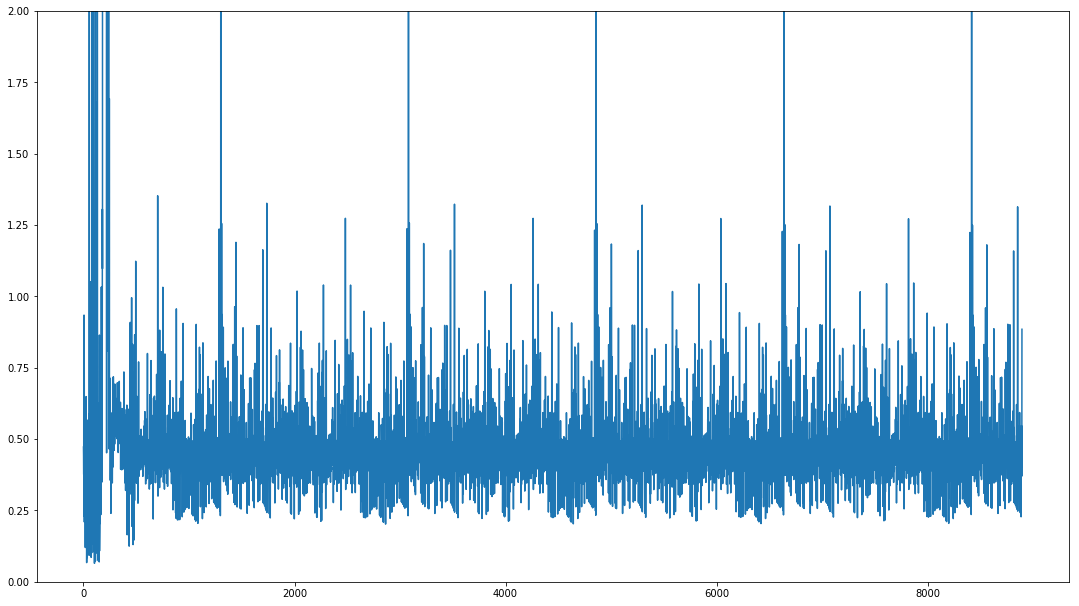

In [73]:
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.plot(losses)
ax.set_ylim(0, 2)

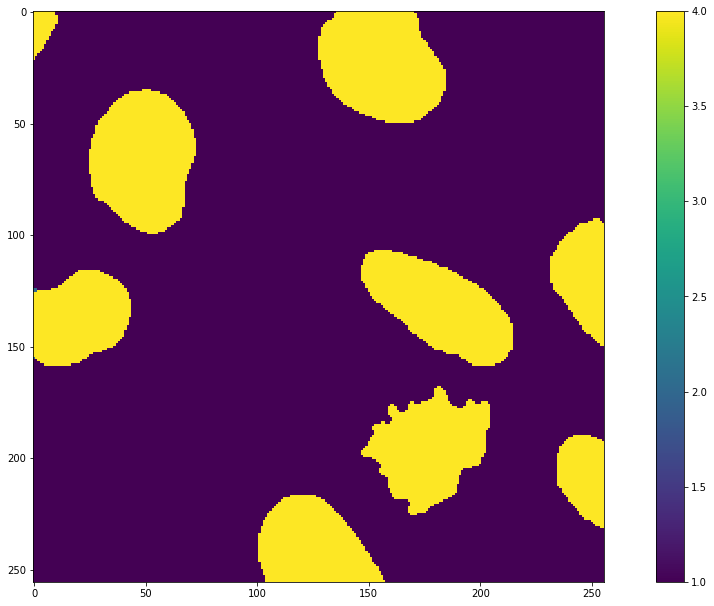

In [87]:
plot(weight[0][0].cpu().data.numpy())

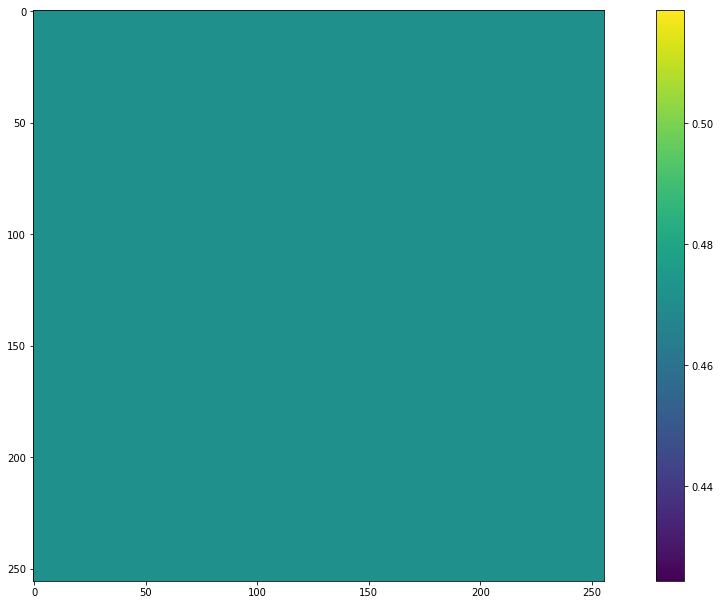

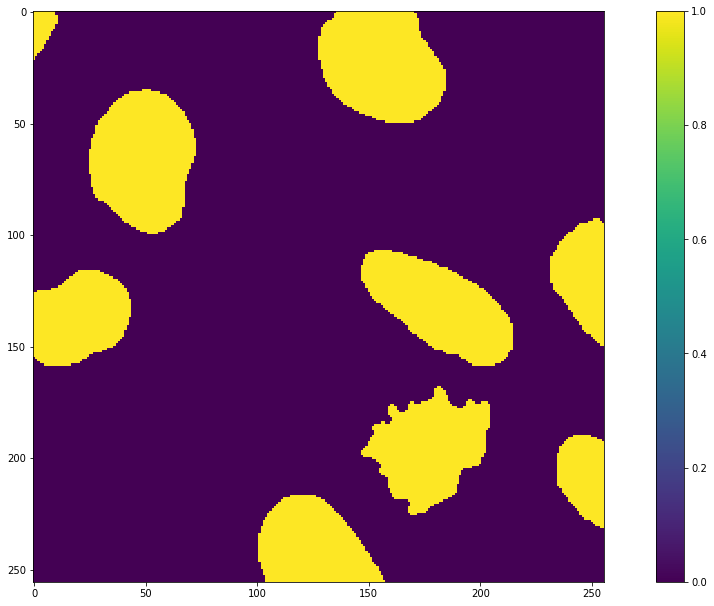

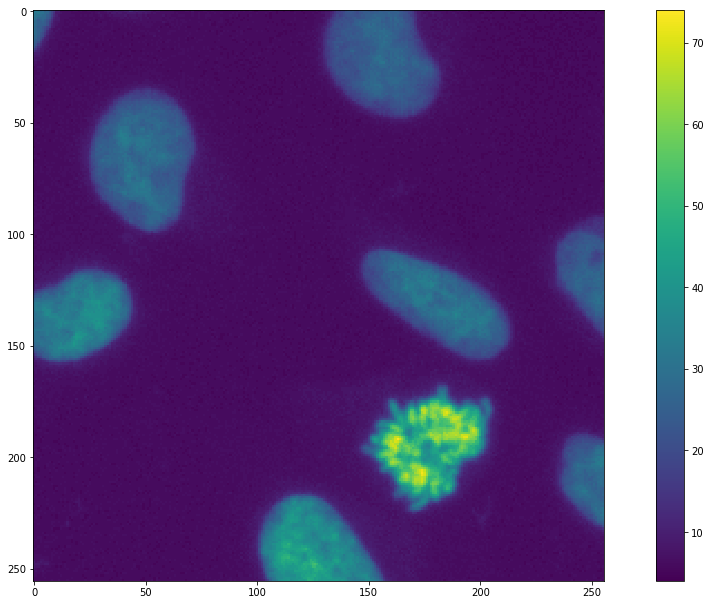

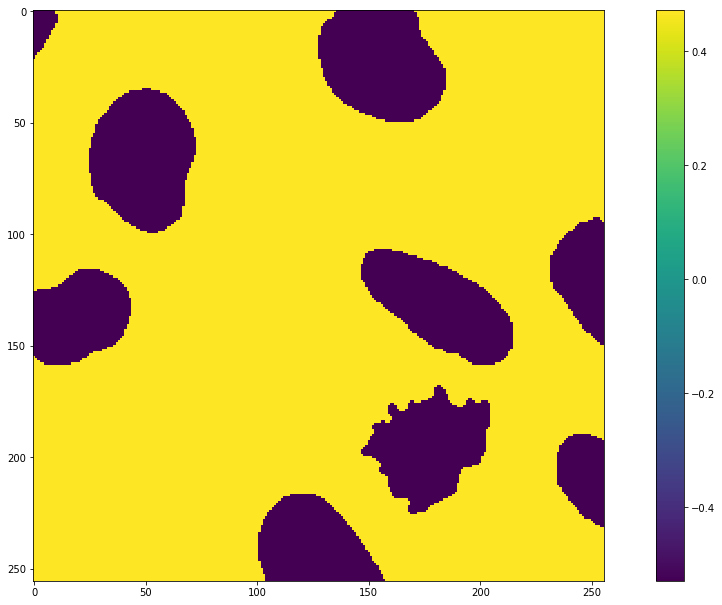

In [88]:
plot(out[0][0].cpu().data.numpy())
plot(exp[0][0].cpu().data.numpy())
plot(inp[0][0][46:-46, 46:-46].cpu().data.numpy())

plot(out[0][0].cpu().data.numpy() - exp[0][0].cpu().data.numpy())


# Validation

In [25]:
loss = 0
results = []
cutoff = 0.7
for i in range(len(validV)):
    inp = validV[i:i+1]
    inp = torch.nn.ReflectionPad2d((348-256)//2)(inp).cuda()
    out = n(inp)[:,:,2:-2,2:-2]
    
    results.append(out.data[0][0] > cutoff)
    
    weight = valid_weightsV[i:i+1].cuda()
    assert weight.shape == (batchsize, 1, 256, 256)
    exp = valid_summary_masksV[i:i+1].cuda()
    loss += (weight * (exp - out.data)**2).mean()
    
print(loss)

4.58318772749044


In [ ]:
plot(results[0])
plot(valid_summary_masks[0].astype(np.int))

# Test

In [74]:
test_raw, test_keys_raw = data_loaders.test_images()

In [75]:
shapes = {}
keys = {}
for i in range(len(test_raw)):
    shape = test_raw[i].shape
    try:
        shapes[shape].append(test_raw[i])
        keys[shape].append(test_keys_raw[i])
    except:
        shapes[shape] = [test_raw[i]]
        keys[shape] = [test_keys_raw[i]]

In [76]:
for k, v in shapes.items():
    shapes[k] = h.tensorfy(v)

In [77]:
shapes.keys()

dict_keys([(256, 256), (520, 348), (512, 680), (512, 640), (520, 696), (519, 161), (519, 162), (260, 347), (524, 348), (519, 253), (390, 239)])

In [80]:
inp_size = 348
results, results_keys = [], []
cutoff = 0.4
for shp, images in shapes.items():
    y_cut, x_cut = imcut.patchify(shp)

    for img_index in range(len(images)):
        res = np.zeros(shp)
        for i in range(len(y_cut) - 1):
            for j in range(len(x_cut) - 1):
                
                height = y_cut[i+1] - y_cut[i]
                width = x_cut[j+1] - x_cut[j]
                inp = images[img_index:img_index+1,:,y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]]
                orig_shape = inp.shape
                
                width_pad = (inp_size-width)//2
                height_pad = (inp_size-height)//2
                inp = torch.nn.ReflectionPad2d(
                    (width_pad, width_pad, height_pad, height_pad),
                )(inp).cuda()
                assert inp.shape == (1, 1, inp_size, inp_size)
                
                width_unpad = (260 - width) // 2
                height_unpad = (260 - height) // 2
                out = n(inp)[:,:,height_unpad:-height_unpad,width_unpad:-width_unpad]
                assert out.shape == orig_shape
                
                res[y_cut[i]:y_cut[i+1],x_cut[j]:x_cut[j+1]] = out.data
        results.append((res > cutoff).astype(np.int))
        results_keys.append(keys[shp][img_index])

65


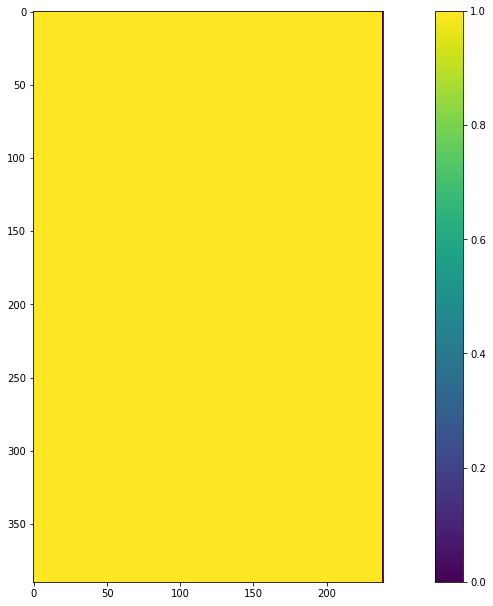

In [81]:
plot(results[-1])
prepare_submission.write_submission(
    "test_nn_out",
    [prepare_submission.remove_tiny_masks(prepare_submission.separate_masks(i)) for i in results],
    results_keys)

In [83]:
res

array([[0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ],
       [0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ],
       [0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ],
       ...,
       [0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ],
       [0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ],
       [0.47152817, 0.47152817, 0.47152817, ..., 0.47152817, 0.47152817,
        0.        ]])